Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [30]:
HYPERTRAINING = False
CV = 5
SAVE_MODEL_NAME = "trained_classifier_models"
SCORING = 'recall'
CLASS_WEIGHTS = 'balanced'
EXPERIEMENT_NAME = "offensive_predictor_model_selection"
RUN_NAME = None
TARGET_OVERALL = 80

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental'
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', '',
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'age_based_shooting_technique', 'Crossing',  'HeadingAccuracy', 'ShortPassing','Dribbling',    'BallControl',
                     'SprintSpeed', 'Agility','Composure', 'Reactions', 
                       'Stamina', 'Aggression', 'Interceptions', 'Positioning', 'Vision']


In [31]:
import os
import pandas as pd
import numpy as np
import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")
find_and_append_module_path()
os.getcwd()

from src.sport_analytics.model.prepare import add_features_raw_datadf_raw
import config as CONFIG
from src.sport_analytics.model.eval import plot_feature_importance,plot_shap_summary,plot_auc_curves

New current directory: c:\Users\Robert\Documents\Projekte\dev\statsfaction


### Get Data

In [32]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [33]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import sqlite3
DATABASE_PATH = "data/sport_analytics/database/football.db"
# Step 1: Establish a database connection
conn = sqlite3.connect(DATABASE_PATH)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw_datadf_raw(df_raw)

df_raw.head()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,overall_age_ratio,youth_player,shooting,shooting_technique,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,0.170132,False,87.666667,85.4,NaN,67.0,91.0,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,0.142400,False,88.333333,89.2,NaN,82.5,93.5,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,€105K,1911.0,"RW,LW,CAM",12092.0,69.0,73.0,66.0,71.0,66.0,85.0,84.0,56.0,67.0,83.0,81.0,78.0,83.0,79.0,67.0,74.0,63.0,77.0,71.0,74.0,53.0,32.0,74.0,75.0,67.0,NaN,34.0,32.0,5.0,9.0,6.0,15.0,7.0,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0,0.195000,False,67.666667,68.6,75.5,74.0,79.5,80.2,12.425926,9.250000,16.803704,9.037037,15.351852,15.092593,19.259259,14.574074,15.234568
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,0.224377,True,73.333333,70.6,NaN,65.0,86.5,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0,0.218837,True,78.000000,72.0,78.0,63.0,87.0,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516


# 

In [34]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'test', 2020: 'test', 2021: 'test', 2022: 'test', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Overall<TARGET_OVERALL)&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [35]:

df = df[df.prime_age>df.potential_age]
df['target'] = df.PrimeOverall>=TARGET_OVERALL
df = df[df.potential_age<26]
df = df[df.offense>0.5]
print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()
df_processed.head()

target
False    627
True     218
Name: count, dtype: int64


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Position,Unnamed: 0,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense,overall_age_ratio,youth_player,shooting,shooting_technique,mental,physique,Speed,ball_handling,age_based_Reactions,age_based_physique,age_based_shooting_technique,age_based_Stamina,age_based_Positioning,age_based_Vision,age_based_Finishing,age_based_BallControl,age_based_shooting,set,target
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,€0,2121.0,"RW,RF,ST,CAM",11360.0,85.0,91.0,69.0,89.0,88.0,97.0,87.0,82.0,75.0,96.0,94.0,88.0,96.0,89.0,86.0,79.0,64.0,75.0,59.0,87.0,48.0,22.0,90.0,91.0,86.0,13.0,21.0,20.0,6.0,11.0,15.0,14.0,8.0,NaN,NaN,95.0,24.0,94.0,RW,0,1,1.0,13.0,0.170132,False,87.666667,85.4,NaN,67.0,91.0,94.2,15.742424,-4.863636,26.616667,1.750000,30.401515,22.386364,35.196970,25.765152,31.424242,drop,True
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,€0,2223.0,"RW,CAM,LW,ST",11359.0,84.0,89.0,87.0,81.0,85.0,93.0,88.0,88.0,71.0,95.0,93.0,94.0,94.0,88.0,84.0,93.0,91.0,85.0,80.0,91.0,61.0,24.0,88.0,80.0,82.0,22.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0,0.142400,False,88.333333,89.2,NaN,82.5,93.5,92.2,13.169643,8.799107,26.707143,10.535714,26.562500,9.500000,30.133929,23.366071,28.907738,drop,True
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,€0,1958.0,"RW,LW,CF,RM",11226.0,74.0,76.0,64.0,80.0,67.0,84.0,68.0,64.0,68.0,86.0,87.0,86.0,83.0,78.0,76.0,72.0,67.0,74.0,56.0,74.0,54.0,42.0,80.0,82.0,75.0,35.0,32.0,29.0,11.0,12.0,6.0,8.0,8.0,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0,0.224377,True,73.333333,70.6,NaN,65.0,86.5,83.0,11.125000,-0.210227,16.313636,6.477273,22.250000,21.750000,22.977273,18.102273,19.503788,drop,True
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,€90K,1929.0,"RW,LW",12571.0,72.0,78.0,62.0,73.0,67.0,84.0,80.0,73.0,57.0,80.0,88.0,86.0,87.0,78.0,85.0,71.0,73.0,81.0,45.0,71.0,54.0,21.0,83.0,71.0,74.0,NaN,36.0,32.0,9.0,8.0,12.0,8.0,5.0,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0,0.218837,True,78.000000,72.0,78.0,63.0,87.0,83.2,17.019608,0.872549,23.164706,16.372549,28.725490,14.196078,28.137255,15.431373,28.457516,test,True
208790,Z. Bakkali,2014,17.0,17.0,https://cdn.sofifa.net/players/208/790/14_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,73.0,90.0,PSV,https://cdn.sofifa.net/meta/team/682/30.png,€2.1M,€30K,1734.0,"RW,LW",9423.0,64.0,64.0,27.0,62.0,69.0,86.0,74.0,67.0,52.0,78.0,87.0,83.0,87.0,66.0,92.0,69.0,68.0,57.0,30.0,72.0,36.0,25.0,65.0,67.0,56.0,25.0,25.0,25.0,10.0,5.0,15.0,11.0,15.0,NaN,NaN,90.0,20.0,74.0,RW,0,1,1.0,25.0,0.252595,True,65.333333,68.2,NaN,43.5,85.0,84.2,11.363636,-8.681818,15.927273,0.545455,12.636364,10.272727,10.454545,11.545455,12.030303,train,False


In [36]:
df_processed.best_position.value_counts()

best_position
ST    487
LW    141
RW    124
CF     75
RF     10
LF      8
Name: count, dtype: int64

In [37]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,24.0,95.0,95.0,90.0,94.0,True,drop,RW
20801,Cristiano Ronaldo,2011,25.0,25.0,31.0,94.0,94.0,89.0,94.0,True,drop,RW
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,True,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,True,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,False,train,RW


In [38]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

## Deskriptive Analyse

In [39]:
df.select_dtypes(exclude='object').corr()['target'].round(2).sort_values().head(100)

youth_player        -0.21
overall_age_ratio   -0.09
GKPositioning       -0.05
central             -0.05
GKReflexes          -0.01
                     ... 
Special              0.46
Overall              0.50
PrimeOverall         0.74
target               1.00
offense               NaN
Name: target, Length: 66, dtype: float64

In [40]:
df[df.Age<20].describe().round(0).compare(df[df.Age>=20].describe().round(0))

potential_age           Age        Overall        Potential         \
               self  other   self  other    self  other      self  other   
count         384.0  461.0  384.0  461.0   384.0  461.0     384.0  461.0   
mean           18.0   22.0   18.0   22.0    66.0   73.0       NaN    NaN   
std             1.0    2.0    1.0    2.0     4.0    5.0       NaN    NaN   
min            16.0   20.0   16.0   20.0    54.0   58.0       NaN    NaN   
25%            18.0   21.0   18.0   21.0    63.0   70.0      81.0   80.0   
50%            18.0   22.0   18.0   22.0    66.0   73.0       NaN    NaN   
75%            19.0   23.0   19.0   23.0    69.0   76.0       NaN    NaN   
max            19.0   25.0   19.0   25.0    81.0   90.0      91.0   95.0   

      Special         Unnamed: 0          Crossing        Finishing         \
         self   other       self    other     self  other      self  other   
count   384.0   461.0      384.0    461.0    384.0  461.0     384.0  461.0   
mean   1611.0  1795.0     7059.0  10261.0     52.0   60.0      65.0   73.0   
std     120.0   133.0     2952.0   2212.0     12.0   13.0       NaN    NaN   
min    1303.0  1462.0      793.0   2156.0     20.0   22.0      34.0   42.0   
25%    1530.0  1711.0     4966.0   9224.0     42.0   54.0      62.0   69.0   
50%    1594.0  1791.0     6788.0  10312.0     52.0   62.0      66.0   73.0   
75%    1694.0  1877.0     8966.0  11211.0     61.0   69.0      69.0   77.0   
max    1979.0  2316.0    16494.0  17148.0     78.0   89.0      85.0   92.0   

      HeadingAccuracy        ShortPassing        Volleys        Dribbling  \
                 self  other         self  other    self  other      self   
count           384.0  461.0        384.0  461.0   384.0  461.0     384.0   
mean             55.0   63.0         60.0   67.0    56.0   66.0      69.0   
std              11.0   12.0          NaN    NaN     8.0    9.0       NaN   
min              17.0   27.0         33.0   27.0     NaN    NaN      45.0   
25%              49.0   56.0         55.0   63.0    51.0   61.0      64.0   
50%              57.0   64.0         59.0   68.0    57.0   67.0      69.0   
75%              64.0   72.0         65.0   72.0    62.0   72.0      74.0   
max              78.0   92.0         82.0   89.0    81.0   91.0      87.0   

              Curve        FKAccuracy        LongPassing        BallControl  \
       other   self  other       self  other        self  other        self   
count  461.0  384.0  461.0      384.0  461.0       384.0  461.0       384.0   
mean    74.0   55.0   63.0       47.0   55.0        48.0   55.0        68.0   
std      NaN   11.0   12.0       12.0   14.0        10.0   11.0         NaN   
min     52.0   27.0   30.0       24.0   22.0         NaN    NaN        51.0   
25%     70.0   47.0   56.0       38.0   45.0        40.0   47.0        64.0   
50%     74.0   55.0   64.0       44.0   55.0        47.0   56.0        68.0   
75%     79.0   63.0   71.0       55.0   67.0        55.0   63.0        72.0   
max     97.0   81.0   88.0       81.0   88.0        72.0   84.0        86.0   

             Acceleration        SprintSpeed        Agility        Reactions  \
       other         self  other        self  other    self  other      self   
count  461.0        384.0  461.0       384.0  461.0   384.0  461.0     384.0   
mean    74.0         77.0   79.0        77.0   79.0    73.0   76.0      61.0   
std      NaN          NaN    NaN         8.0    7.0    10.0    9.0       8.0   
min     53.0         41.0   51.0        49.0   53.0    33.0   30.0      36.0   
25%     70.0         72.0   74.0        72.0   75.0    67.0   71.0      56.0   
50%     74.0         77.0   79.0        77.0   79.0    73.0   76.0      61.0   
75%     78.0         83.0   85.0        83.0   84.0    80.0   82.0      66.0   
max     96.0         94.0   95.0        93.0   95.0    95.0   96.0      82.0   

             Balance        ShotPower        Jumping        Stamina         \
       other    self  o

In [41]:
df[df.target].describe().round(3)
pd.set_option('display.max_columns', 3000)
bool_age = df.Age == 20
df[df.target&bool_age].describe().round(3).compare(df[~df.target&bool_age].describe().round(0))



potential_age         Age       Overall       Potential         Special  \
               self other  self other    self other      self other      self   
count          25.0  82.0  25.0  82.0  25.000  82.0     25.00  82.0    25.000   
mean            NaN   NaN   NaN   NaN  73.560  69.0     83.08  82.0  1804.080   
std             NaN   NaN   NaN   NaN   4.727   4.0      2.90   2.0   136.684   
min             NaN   NaN   NaN   NaN  63.000  58.0       NaN   NaN  1489.000   
25%             NaN   NaN   NaN   NaN  70.000  67.0       NaN   NaN  1714.000   
50%             NaN   NaN   NaN   NaN  75.000  69.0     83.00  82.0  1787.000   
75%             NaN   NaN   NaN   NaN  76.000  72.0     84.00  83.0  1905.000   
max             NaN   NaN   NaN   NaN  85.000  76.0     91.00  87.0  2058.000   

              Unnamed: 0          Crossing       Finishing        \
        other       self    other     self other      self other   
count    82.0     25.000     82.0   25.000  82.0    25.000  82.0   
mean   1687.0  10496.400   9092.0   60.720  55.0    72.600  68.0   
std     111.0   2424.584   2661.0   11.334  13.0     6.096   6.0   
min    1478.0   5463.000   2156.0   29.000  26.0    60.000  42.0   
25%    1603.0   9217.000   7608.0   59.000  45.0    70.000  65.0   
50%    1688.0  10519.000   9412.0   62.000  59.0    73.000  69.0   
75%    1773.0  11692.000  10406.0   68.000  65.0    76.000  73.0   
max    1998.0  16184.000  15364.0   74.000  78.0    86.000  81.0   

      HeadingAccuracy       ShortPassing       Volleys       Dribbling        \
                 self other         self other    self other      self other   
count          25.000  82.0       25.000  82.0  25.000  82.0    25.000  82.0   
mean           63.000  59.0       67.000  64.0  64.320  61.0    76.480  71.0   
std             8.261  12.0        7.506   6.0   8.736   8.0     7.264   6.0   
min            45.000  31.0       53.000  39.0  46.000  40.0    62.000  58.0   
25%            60.000  52.0       62.000  60.0  60.000  55.0    72.000  67.0   
50%            65.000  61.0       67.000  64.0  65.000  62.0    77.000  71.0   
75%            68.000  66.0       73.000  68.0  69.000  66.0    81.000  75.0   
max            76.000  83.0       80.000  76.0  80.000  78.0    90.000  86.0   

       Curve       FKAccuracy       LongPassing       BallControl        \
        self other       self other        self other        self other   
count  25.00  82.0     25.000  82.0      25.000  82.0      25.000  82.0   
mean   65.16  57.0     55.600  49.0      54.320  51.0      75.320  71.0   
std     8.40  10.0     11.683  13.0      10.819  10.0       6.713   5.0   
min    48.00  32.0     33.000  26.0      30.000  28.0      65.000  55.0   
25%    58.00  50.0     50.000  40.0      50.000  44.0      71.000  68.0   
50%    66.00  59.0     56.000  48.0      56.000  52.0      75.000  70.0   
75%    72.00  64.0     62.000  58.0      62.000  58.0      78.000  74.0   
max      NaN   NaN     76.000  74.0      74.000  71.0      92.000  82.0   

      Acceleration       SprintSpeed       Agility       Reactions        \
              self other        self other    self other      self other   
count       25.000  82.0      25.000  82.0  25.000  82.0    25.000  82.0   
mean        81.040  78.0      81.160  77.0  77.840  74.0    73.480  66.0   
std          9.094   8.0       6.884   7.0   9.831  10.0     5.075   6.0   
min         57.000  53.0      66.000  53.0  52.000  45.0    64.000  48.0   
25%         76.000  74.0      77.000  73.0  73.000  68.0    70.000  62.0   
50%         81.000  78.0      80.000  77.0  78.000  76.0    73.000  66.0   
75%         88.000  84.0      86.000  83.0  83.000  80.0    76.000  70.0   
max         92.000  94.0         NaN   NaN  95.000  92.0    84.000  79.0   

      Balance       ShotPower       Jumping       Stamina       Strength  \
         self other      self other    self other    self other     self   
count  25.000  82.0    25.000  82.0  25.000  82.0

###  Feature Engineering

#### Transform Value

In [42]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

In [43]:
df['target'].value_counts()

target
False    627
True     218
Name: count, dtype: int64

In [44]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [45]:


from sklearn.model_selection import train_test_split
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [46]:
(~y_train).sum()


281

In [47]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')

import pandas as pd

from sklearn.preprocessing import StandardScaler
# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [48]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'criterion': 'entropy',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestClassifier(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAMS_RF = {}

In [49]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),  # Adjust the range
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),  # Adjust the range
            'max_features': trial.suggest_float('max_features', 0.1, 1.0),
            'criterion': 'gini',  # or 'entropy' depending on your problem
            'random_state': 42
        }

        # Create the Decision Tree classifier with the given hyperparameters
        clf = DecisionTreeClassifier(**params)

        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring='recall_macro')
        mean_auc = cv_scores.mean()

        return mean_auc

    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_DT = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_DT)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_DT = {}

In [50]:
import optuna
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'objective': 'binary:logistic',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1.0, 20.0),
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
            'reg_alpha': trial.suggest_uniform('reg_alpha', 0.1, 1.0),
            'reg_lambda': trial.suggest_uniform('reg_lambda', 0.01, 0.1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        }
        # Implement early stopping with cross-validation
        cv_scores = []

        clf = XGBClassifier(**params, random_state=42, n_jobs=-1)
        # Implement cross-validation to calculate mean AUC
        cv_scores = cross_val_score(clf, X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_auc = cv_scores.mean()

        return mean_auc
    # Create an Optuna study for maximizing AUC
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)  # You can increase n_trials for more optimization

    PARAM_XGB = study.best_params
    best_auc = study.best_value

    print("Best hyperparameters:", PARAM_XGB)
    print(f"Best {SCORING}:", best_auc)
else:
    PARAM_XGB = {}


# TODOS
- f1 Score für false Predictions -> DONE
- save shap values für alle Modelle -> DONE
- plots in einem Ordner saven -> DONE
- Random State hinzufügen -> DONE
- Vereinfachung des Codes -> DONE

2023/11/25 18:12:04 INFO mlflow.tracking.fluent: Experiment with name 'offensive_predictor_model_selection' does not exist. Creating a new experiment.


Decision Tree Classifier training----->


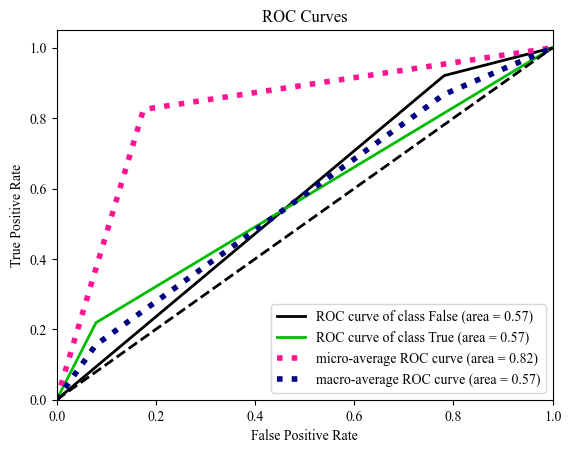

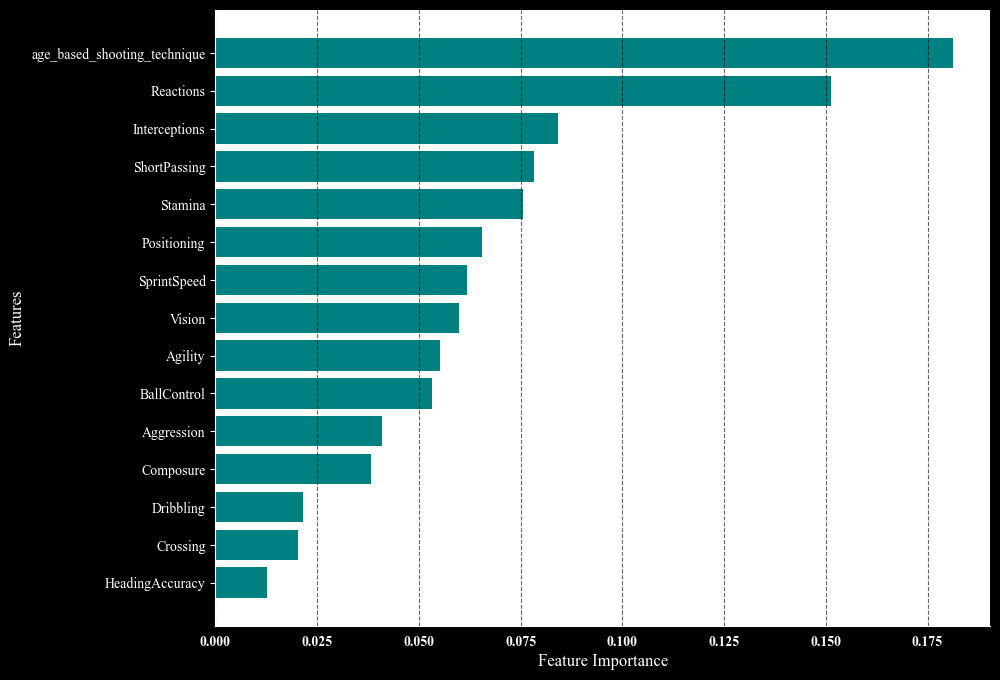

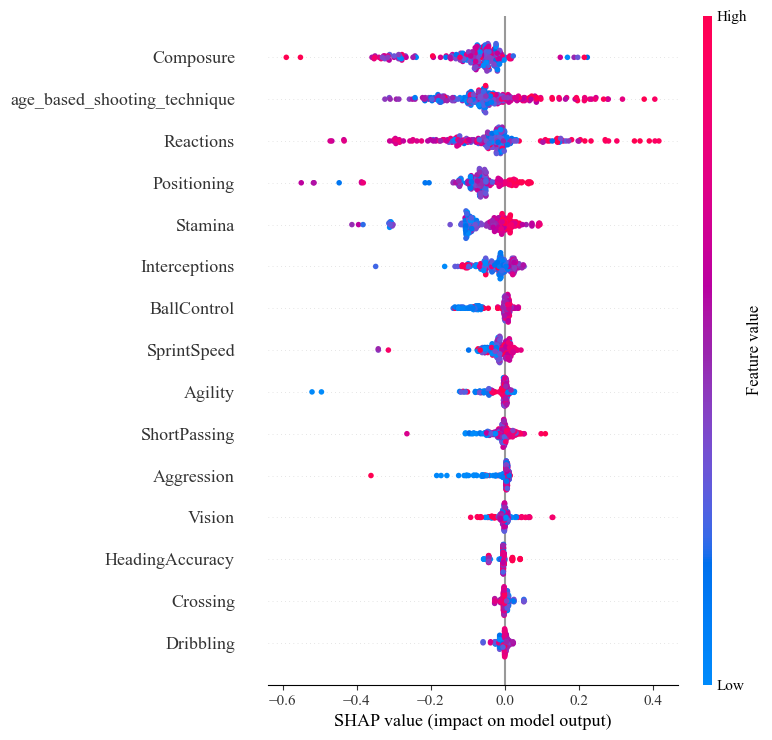

Random Forest Classifier training----->


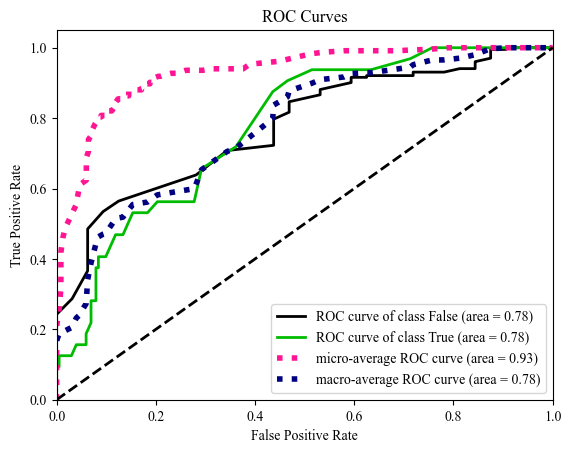

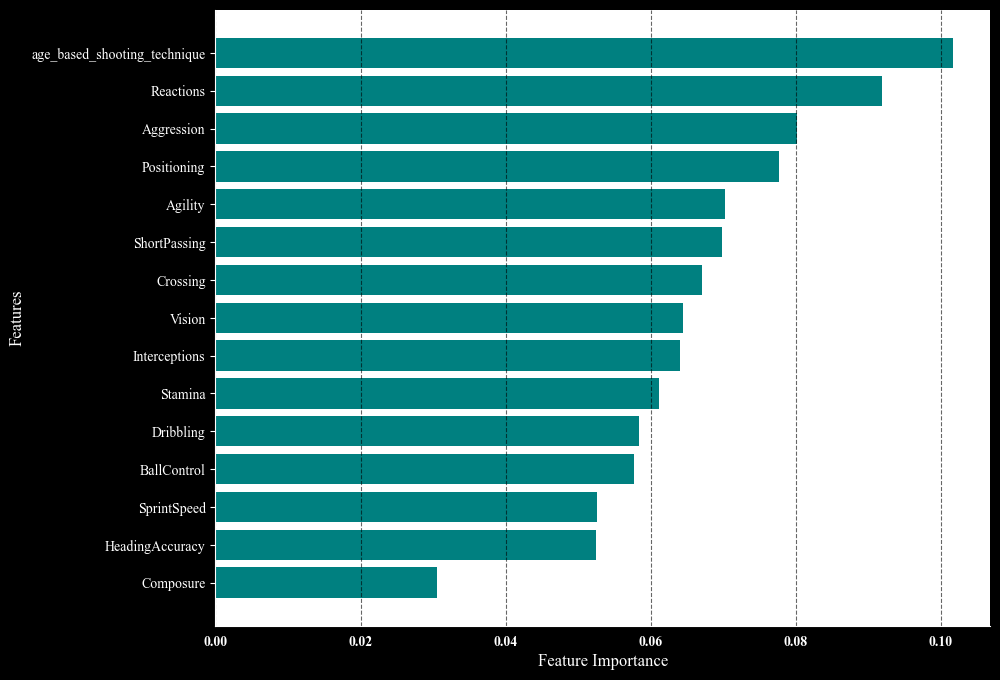

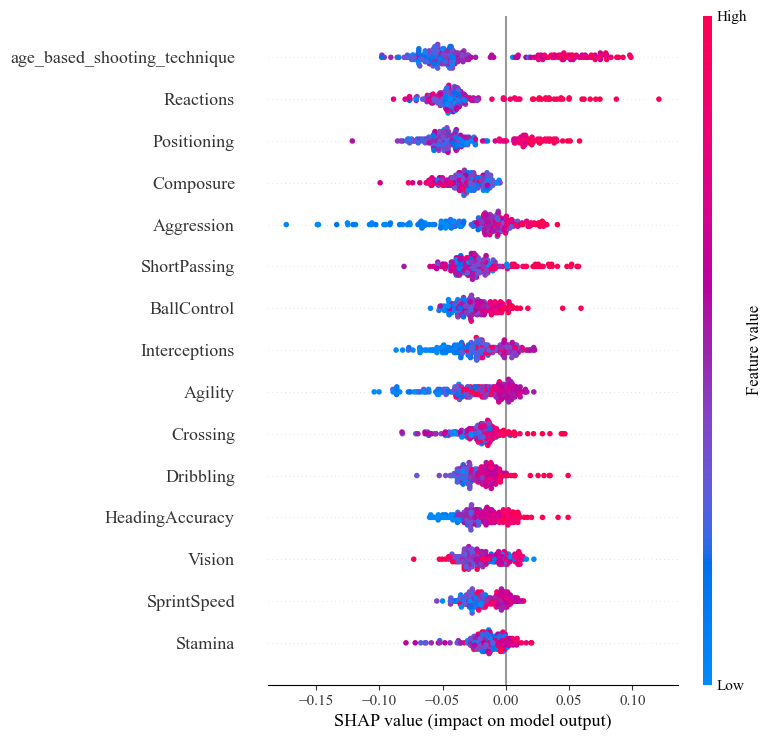

XGBoost Classifier training----->


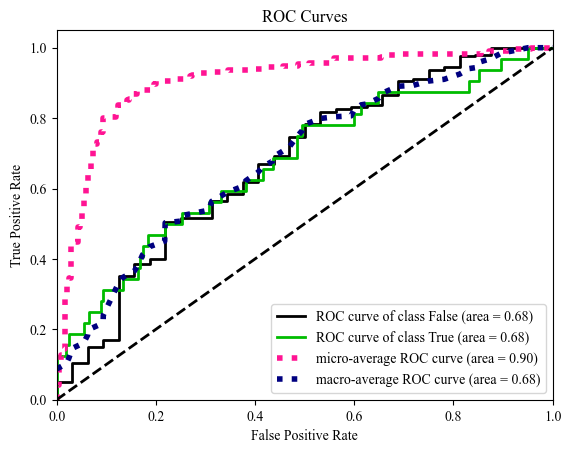

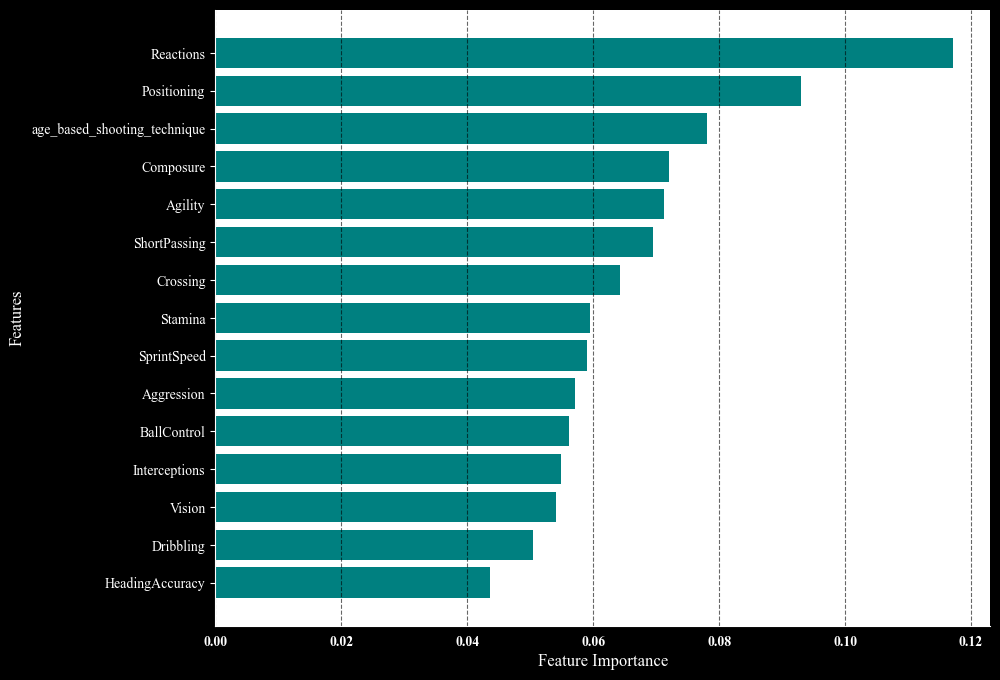

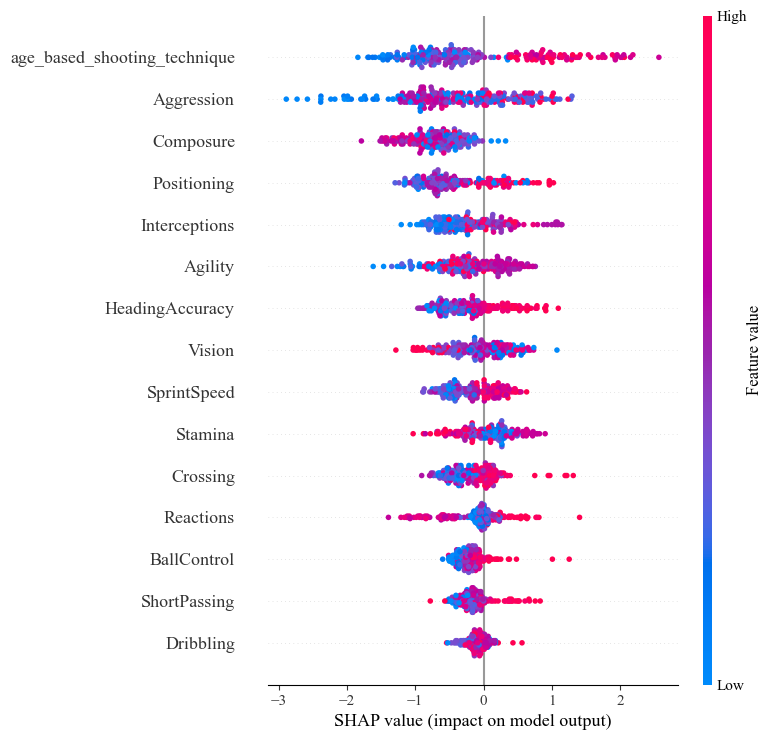

LightGBM Classifier training----->
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 102, number of negative: 281
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 383, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266319 -> initscore=-1.013382
[LightGBM] [Info] Start training from score -1.013382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

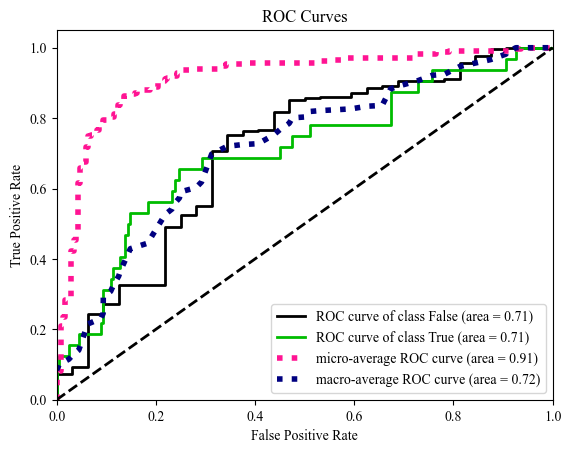

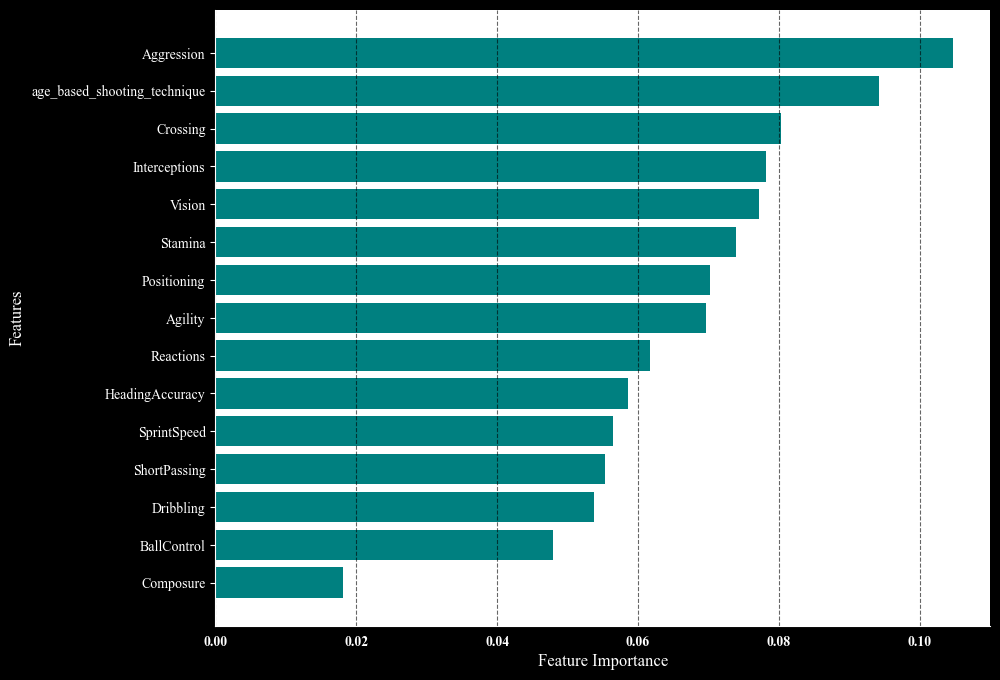

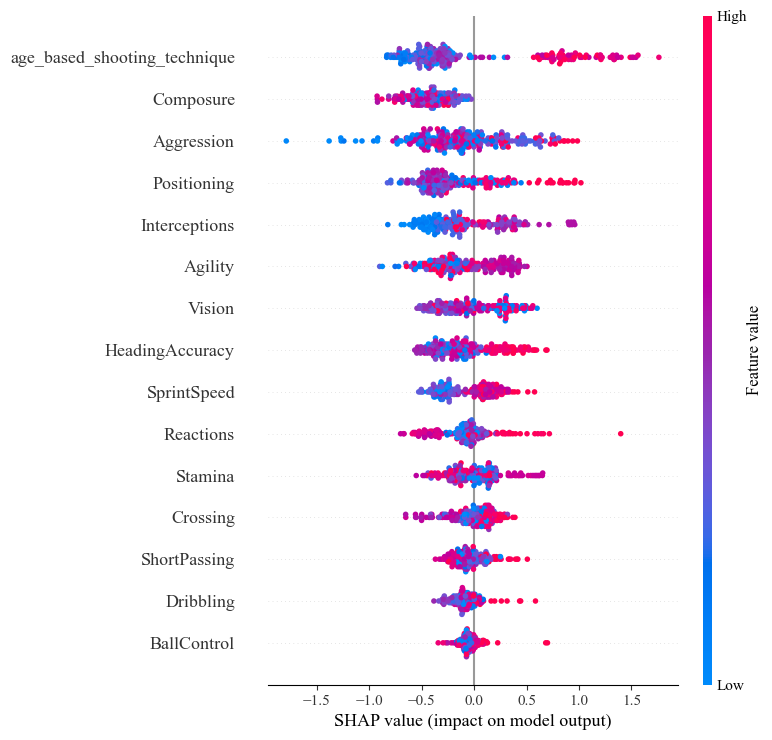

Model: Decision Tree Classifier
Accuracy: 0.82
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.92      0.90       202
        True       0.30      0.22      0.25        32

    accuracy                           0.82       234
   macro avg       0.59      0.57      0.58       234
weighted avg       0.80      0.82      0.81       234

Confusion Matrix:
[[186  16]
 [ 25   7]]
AUC: 0.57
Precision: 0.30

Model: Random Forest Classifier
Accuracy: 0.86
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.98      0.93       202
        True       0.50      0.12      0.20        32

    accuracy                           0.86       234
   macro avg       0.69      0.55      0.56       234
weighted avg       0.82      0.86      0.83       234

Confusion Matrix:
[[198   4]
 [ 28   4]]
AUC: 0.78
Precision: 0.50

Model: XGBoost Classifier
Accuracy: 0.85
Classification Report:
      

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm
from src.sport_analytics.model.eval import plot_feature_importance, plot_auc_curves,plot_shap_summary,log_metrics_in_mlflow,log_feature_list_as_artifact
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


# Create and train different classification models with class weights
models = {
    # 'Logistic Regression': LogisticRegression(class_weight=class_weights),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42,class_weight=CLASS_WEIGHTS, **PARAM_DT),
    'Random Forest Classifier': RandomForestClassifier(random_state=42,class_weight=CLASS_WEIGHTS, **PARAMS_RF),
    'XGBoost Classifier': xgb.XGBClassifier(random_state=42,**PARAM_XGB),
    # 'Support Vector Classifier': SVC(class_weight=class_weights, probability=True, kernel='linear'),

    'LightGBM Classifier': lgb.LGBMClassifier(random_state=42,**{'n_estimators': 100, 'max_depth': 7, 'min_child_samples': 7,
                                                  'subsample': 0.8090291881142198, 'colsample_bytree': 0.6278496311554949,
                                                  'learning_rate': 0.17976777947590364, 'reg_alpha': 0.6699371890412207,
                                                  'reg_lambda': 1.5295937299896694})
}

model_results = {}

# Set the experiment name
mlflow.set_experiment(EXPERIEMENT_NAME)

# Start MLflow run with a specific run name and description
for model_name, model in models.items():
    from datetime import datetime
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        model.fit(X_train_scaled_df, y_train)
        y_pred = model.predict(X_test_scaled_df)
        if hasattr(model, 'predict_proba'):
            y_prob = model.predict_proba(X_test_scaled_df)[:, 1]
        else:
            y_prob = None
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")
        
        # Create a dictionary with parameters and their values
        params_to_log = {
            'CLASS_WEIGHTS': CLASS_WEIGHTS,
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(PLAYER_ATTRIBUTES),
            'y_train_positives': y_train.sum(),
            'y_train_negatives': (~y_train).sum(),
            'y_test_positives': y_test.sum(),
            'y_test_negatives': (~y_test).sum(),
            'TARGET_OVERALL':TARGET_OVERALL
        }

        # Log parameters using log_params
        # mlflow.log_params(params_to_log)


        # # Log artifacts
        # mlflow.sklearn.log_model(model, model_name)

        # Evaluation Plots
        plot_auc_curves(y_true = y_test,y_proba = model.predict_proba(X_test_scaled_df))
        plot_feature_importance(model, '',top_n=20)
        plot_shap_summary(model=model,df=X_test_scaled_df)

        # Evaluation Metrics
        log_metrics_in_mlflow(y_test=y_test,y_prob=y_prob,y_pred=y_pred)


        # Output for quick evaluation
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision_pos, recall_pos, f1_pos, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average='binary')

        if y_prob is not None:
                roc_auc = roc_auc_score(y_test, y_prob)
        else:
            roc_auc = None
        
        
        model_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'attributes': PLAYER_ATTRIBUTES,
            'Accuracy': accuracy,
            'Classification Report': report,
            'Confusion Matrix': conf_matrix,
            'AUC': roc_auc,
            'recall':recall_pos,
            'f1':f1_pos,
            'Precision': precision_pos
        }


# Evaluate and print results for each model
for model_name, results in model_results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {results['Accuracy']:.2f}")
    print("Classification Report:")
    print(results['Classification Report'])
    print("Confusion Matrix:")
    print(results['Confusion Matrix'])
    if results['AUC'] is not None:
        print(f"AUC: {results['AUC']:.2f}")
    if 'Precision' in results:
        print(f"Precision: {results['Precision']:.2f}")
    print()


In [52]:
from src.sport_analytics.model.utils import *
if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.TRAINED_MODELS}/{SAVE_MODEL_NAME}.pkl")

NameError: name 'regression_results' is not defined

# evaluate Model

In [ ]:
my_model = model_results['Random Forest Classifier']['Model']

false_positives = (my_model.predict_proba(X_test_scaled_df)[:,1]>0.5)&(~y_test)
X_test_scaled_df[false_positives]



,,,age_based_shooting_technique,Crossing,HeadingAccuracy,ShortPassing,Dribbling,BallControl,Overall,SprintSpeed,Agility,Composure,Reactions,Stamina,Aggression,Interceptions,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,
257536,J. Kuchta,2022,1.488723,0.219908,1.084290,0.606107,-0.296735,0.164818,0.879974,0.022751,-0.047759,1.737038,0.863366,1.321224,2.494321,0.252322,1.015672,0.615982
244193,Jovane Cabral,2021,1.869891,1.313735,-0.235116,0.855182,1.283558,0.936521,1.268035,1.078957,1.045757,2.007685,1.102981,0.302685,0.561443,-0.552168,0.765026,1.150465


In [ ]:
false_negatives = (my_model.predict_proba(X_test_scaled_df)[:,1]<0.3)&(y_test)
X_test_scaled_df[false_negatives]

,,,age_based_shooting_technique,Crossing,HeadingAccuracy,ShortPassing,Dribbling,BallControl,Overall,SprintSpeed,Agility,Composure,Reactions,Stamina,Aggression,Interceptions,Positioning,Vision
ID,Name,FIFA,,,,,,,,,,,,,,,,
241852,M. Diaby,2019,-0.315211,-0.405136,-1.966836,-0.016583,-0.033353,-0.298204,-1.060326,0.286803,0.648115,1.331066,-1.412979,-1.364016,-0.543059,0.252322,-1.616110,-0.239192
235944,Brais Méndez,2019,1.115030,0.610561,-0.647430,1.228796,0.230030,0.782180,0.491914,-1.165480,-0.544811,1.601714,0.863366,0.302685,-1.026278,0.855689,0.765026,1.257362
233500,L. Sinisterra,2020,-0.437340,0.298038,0.259661,0.232493,0.098338,-0.606885,-0.284206,0.154777,1.443399,1.534052,-0.334711,0.858252,0.492412,-1.256096,-0.112234,0.509085
251852,K. Adeyemi,2021,1.573155,0.376169,0.177198,0.357031,0.361721,0.164818,-0.284206,1.210982,1.145167,1.669376,-0.454518,-0.808449,-1.026278,-1.155535,-0.738849,0.509085
246191,J. Álvarez,2020,1.049954,0.219908,0.012273,-0.141121,-0.560117,0.010477,-0.672266,-0.109275,0.151062,1.500221,-0.095095,-0.345477,-1.302404,-0.351045,-0.488203,-0.132295
240243,Matheus Cunha,2019,0.620678,0.610561,0.094735,-0.888349,-1.086881,-1.069907,-0.672266,0.946931,-0.644221,1.500221,-0.574326,0.024901,0.561443,-1.457218,-0.488203,0.081498
239085,E. Håland,2020,1.489093,-0.795789,0.177198,0.357031,-0.033353,0.319159,0.491914,0.550854,-0.942453,1.940023,0.623750,0.580468,2.080133,0.654567,0.514380,-0.452985
246186,Arthur Cabral,2021,0.423415,-0.483267,1.249215,1.104258,0.098338,0.473499,0.879974,-1.033454,-0.743632,1.635545,0.144520,0.302685,0.423380,-0.451606,0.765026,-0.346089
226710,G. Scamacca,2022,1.306574,-2.670922,1.166752,0.606107,-0.296735,0.627840,0.685944,-0.901429,-1.439505,1.500221,-0.574326,-1.178827,0.285318,-0.451606,1.015672,-0.239192
